In [20]:
# Importaciones
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.regularizers import l1_l2, l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Attention, Lambda, Reshape, Permute, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.initializers import GlorotUniform, HeNormal, LecunNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l1_l2
from tensorflow.keras.metrics import Precision, Recall
import math
from keras.optimizers import RMSprop


In [21]:

# Directorios de datos
data_dir_p = 'Database_P'  # Datos para entrenamiento y validación
data_dir_t = 'Database_T'  # Datos para prueba
batch_size = 32
img_height = 180
img_width = 180


In [22]:
def load_images_and_labels(data_dir, target_size=(img_height, img_width)):
    all_images = []
    all_labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith((".png", ".jpg", ".jpeg")):
                    image_path = os.path.join(class_dir, file_name)
                    img = load_img(image_path, target_size=target_size)
                    img_array = img_to_array(img)
                    all_images.append(img_array)
                    all_labels.append(class_name)

    return np.array(all_images), np.array(all_labels)



# Cargar imágenes y etiquetas de ambos directorios
all_images_p, all_labels_p = load_images_and_labels(data_dir_p)
all_images_t, all_labels_t = load_images_and_labels(data_dir_t)

# Codificar etiquetas
le = LabelEncoder()
all_labels_p = le.fit_transform(all_labels_p)
all_labels_t = le.transform(all_labels_t)  # Usar el mismo codificador para consistencia

all_images_p, all_labels_p = load_images_and_labels(data_dir_p)

print(f"Imágenes cargadas de Database_P: {len(all_images_p)}")
print(f"Etiquetas antes de codificar: {all_labels_p}")  # Verifica los nombres de las clases

le = LabelEncoder()
all_labels_p = le.fit_transform(all_labels_p)

print(f"Etiquetas codificadas: {all_labels_p}")  # Verifica los valores numéricos


# Separar datos de entrenamiento y validación (90% train, 10% val)
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images_p, all_labels_p, test_size=0.1, random_state=42, stratify=all_labels_p
)

# Datos de prueba (ya están separados)
test_images, test_labels = all_images_t, all_labels_t

# Convertir etiquetas a enteros (opcional)
train_labels = train_labels.astype(np.int64)
val_labels = val_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

# Crear ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Crear los generadores de flujo de datos
train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=batch_size, shuffle=True)
val_generator = val_test_datagen.flow(x=val_images, y=val_labels, batch_size=batch_size, shuffle=False)  # shuffle=False
test_generator = val_test_datagen.flow(x=test_images, y=test_labels, batch_size=batch_size, shuffle=False)


Imágenes cargadas de Database_P: 7470
Etiquetas antes de codificar: ['defected' 'defected' 'defected' ... 'no_defected' 'no_defected'
 'no_defected']
Etiquetas codificadas: [0 0 0 ... 1 1 1]


In [23]:
def count_images_and_defects(labels, set_name):
    """Counts total images and the number of defective images in a set."""
    unique, counts = np.unique(labels, return_counts=True)
    total = counts.sum()
    
    defective = counts[unique == le.transform(['defected'])[0]].sum() if unique.size > 1 else 0  # If only one class, assume it's not 'defected'
    not_defected = total - defective

    print(f"{set_name}:")
    print(f"  Total Images: {total}")
    print(f"  Defected: {defective}")
    print(f"  Not Defected: {not_defected}\n")


# Count and print for each set
count_images_and_defects(train_labels, "Training Set")
count_images_and_defects(val_labels, "Validation Set")
count_images_and_defects(test_labels, "Test Set")

Training Set:
  Total Images: 6723
  Defected: 3278
  Not Defected: 3445

Validation Set:
  Total Images: 747
  Defected: 364
  Not Defected: 383

Test Set:
  Total Images: 312
  Defected: 152
  Not Defected: 160



In [24]:

# Visualización de datos y análisis
unique_labels = np.unique(train_labels)
class_indices = {label: i for i, label in enumerate(unique_labels)}
class_names = list(class_indices.keys())
print("Clases:", class_names)


Clases: [0, 1]


Clases: [0, 1]


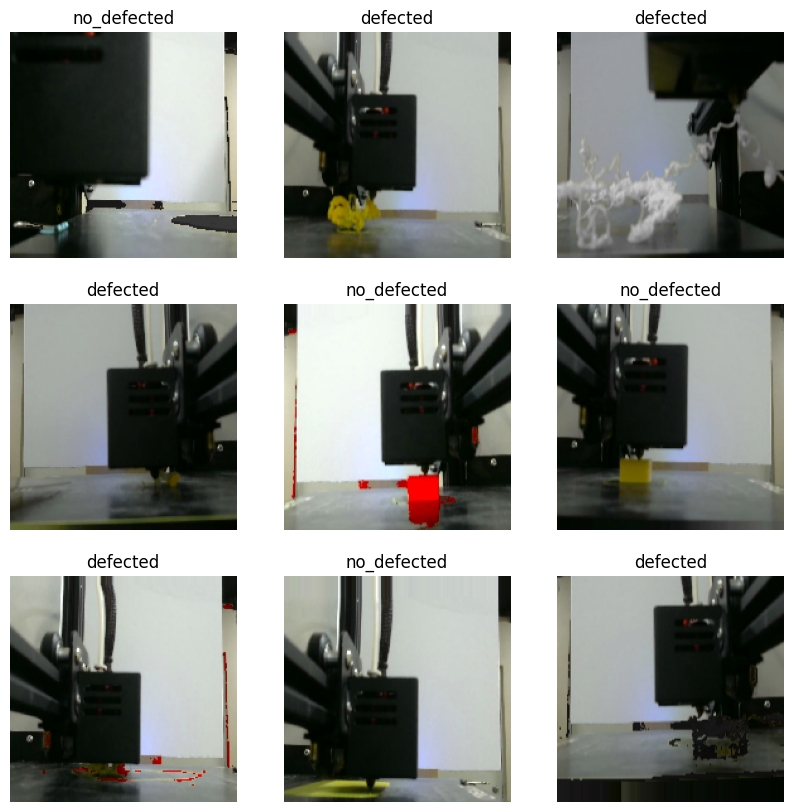

In [25]:
# Conteo de clases y visualización
unique_labels = np.unique(train_labels)  # Obtén etiquetas únicas
class_indices = {label: i for i, label in enumerate(unique_labels)}  # Crea el diccionario
class_names = list(class_indices.keys())
print("Clases:", class_names)

# Visualización de imágenes de entrenamiento
class_names = ['defected', 'no_defected']  # Definir los nombres de las clases explícitamente
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_name = class_names[labels[i]]  # Usar la lista class_names directamente
        plt.title(class_name)
        plt.axis("off")
    break  # Mostrar solo el primer lote
plt.show()


In [26]:

# Imprimir forma de lotes (solo para entrenamiento)
for image_batch, labels_batch in train_generator:
    print("Forma del lote de imágenes:", image_batch.shape)
    print("Forma del lote de etiquetas:", labels_batch.shape)
    break  


Forma del lote de imágenes: (32, 180, 180, 3)
Forma del lote de etiquetas: (32,)


In [27]:

# Calcular los pesos de clase
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Análisis estadístico de características
def calculate_and_plot_statistics(images, labels):
    """Calcula y grafica estadísticas descriptivas para cada canal de color."""
    class0_images = images[labels == 0]
    class1_images = images[labels == 1]

    channels = ['Rojo', 'Verde', 'Azul']
    for i, channel in enumerate(channels):
        class0_channel_values = class0_images[:, :, :, i].flatten()
        class1_channel_values = class1_images[:, :, :, i].flatten()

        mean0 = np.mean(class0_channel_values)
        std0 = np.std(class0_channel_values)
        mean1 = np.mean(class1_channel_values)
        std1 = np.std(class1_channel_values)

        print(f"Canal {channel}:")
        print(f"  Clase defectuoso: Media={mean0:.2f}, Desviación Estándar={std0:.2f}")
        print(f"  Clase no defectuoso: Media={mean1:.2f}, Desviación Estándar={std1:.2f}")


Canal Rojo:
  Clase defectuoso: Media=111.68, Desviación Estándar=78.77
  Clase no defectuoso: Media=109.28, Desviación Estándar=81.82


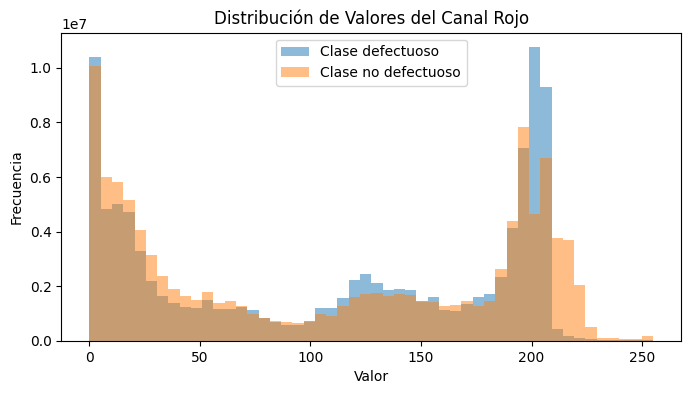

Canal Verde:
  Clase defectuoso: Media=116.28, Desviación Estándar=79.08
  Clase no defectuoso: Media=113.68, Desviación Estándar=81.88


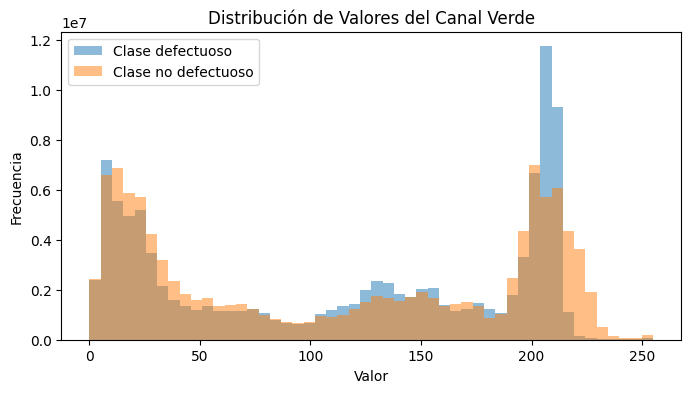

Canal Azul:
  Clase defectuoso: Media=110.51, Desviación Estándar=80.76
  Clase no defectuoso: Media=108.13, Desviación Estándar=83.43


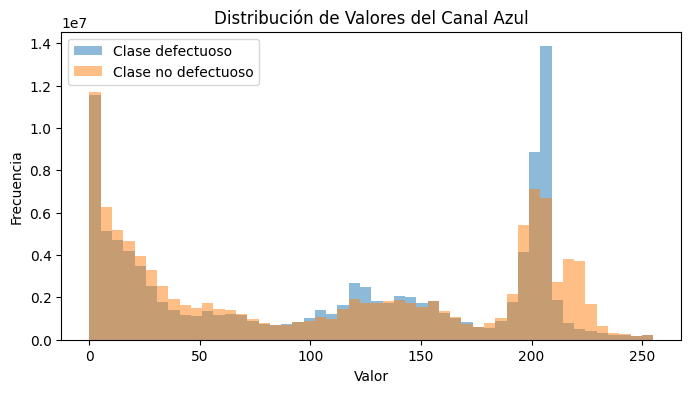

In [28]:
# Análisis estadístico de características (después de cargar y dividir los datos)

def calculate_and_plot_statistics(images, labels):
    """Calcula y grafica estadísticas descriptivas para cada canal de color."""
    # Separar imágenes por clase
    class0_images = images[labels == 0]
    class1_images = images[labels == 1]

    # Calcular estadísticas para cada canal
    channels = ['Rojo', 'Verde', 'Azul']
    for i, channel in enumerate(channels):
        class0_channel_values = class0_images[:, :, :, i].flatten()
        class1_channel_values = class1_images[:, :, :, i].flatten()

        # Calcular media y desviación estándar
        mean0 = np.mean(class0_channel_values)
        std0 = np.std(class0_channel_values)
        mean1 = np.mean(class1_channel_values)
        std1 = np.std(class1_channel_values)

        print(f"Canal {channel}:")
        print(f"  Clase defectuoso: Media={mean0:.2f}, Desviación Estándar={std0:.2f}")
        print(f"  Clase no defectuoso: Media={mean1:.2f}, Desviación Estándar={std1:.2f}")

        # Graficar histogramas (opcional)
        plt.figure(figsize=(8, 4))
        plt.hist(class0_channel_values, bins=50, alpha=0.5, label='Clase defectuoso')
        plt.hist(class1_channel_values, bins=50, alpha=0.5, label='Clase no defectuoso')
        plt.title(f'Distribución de Valores del Canal {channel}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()

# Aplicar al conjunto de entrenamiento
calculate_and_plot_statistics(train_images, train_labels)

In [29]:

# Definición del modelo

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.005), input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Aumento del dropout

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Optimizador RMSprop con tasa de aprendizaje reducida
optimizer = RMSprop(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.summary()

C:\Users\pemor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,257 (30.61 MB)

 Trainable params: 8,023,809 (30.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:

# Entrenamiento con early stopping y reducción de la tasa de aprendizaje
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

def cosine_annealing(epoch, lr):
    initial_lr = 1e-5
    epochs = 30 
    return initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / epochs))

lr_scheduler = LearningRateScheduler(cosine_annealing)

epochs = 30
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30


C:\Users\pemor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 204s 949ms/step - accuracy: 0.6615 - loss: 2.8032 - precision_1: 0.6670 - recall_1: 0.6569 - val_accuracy: 0.5622 - val_loss: 2.6894 - val_precision_1: 0.5394 - val_recall_1: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 187s 876ms/step - accuracy: 0.8256 - loss: 2.3130 - precision_1: 0.8368 - recall_1: 0.8234 - val_accuracy: 0.8527 - val_loss: 2.2176 - val_precision_1: 0.8421 - val_recall_1: 0.8773 - learning_rate: 9.9726e-06
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.8634 - loss: 2.2036 - precision_1: 0.8750 - recall_1: 0.8553 - val_accuracy: 0.8768 - val_loss: 2.1471 - val_precision_1: 1.0000 - val_recall_1: 0.7598 - learning_rate: 9.8907e-06
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.8876 - loss: 2.1250 - precision_1: 0.9014 - recall_1: 0.8725 - val_accuracy: 0.8929 - val_loss: 2.1003 - val_precision_1: 1.0000 - val_recall_1: 0.7911 - learning_rate: 9.7553e-06
Epoch 5/30
211/21

In [31]:

## Evaluación en el conjunto de prueba
results = model.evaluate(test_generator)
print(results)

test_loss, test_acc, *other_metrics = results
print('Pérdida en el conjunto de prueba:', test_loss)
print('Precisión en el conjunto de prueba:', test_acc)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9957 - loss: 1.5355 - precision_1: 0.6364 - recall_1: 0.6257  
[1.5569143295288086, 0.9903846383094788, 1.0, 0.981249988079071]
Pérdida en el conjunto de prueba: 1.5569143295288086
Precisión en el conjunto de prueba: 0.9903846383094788


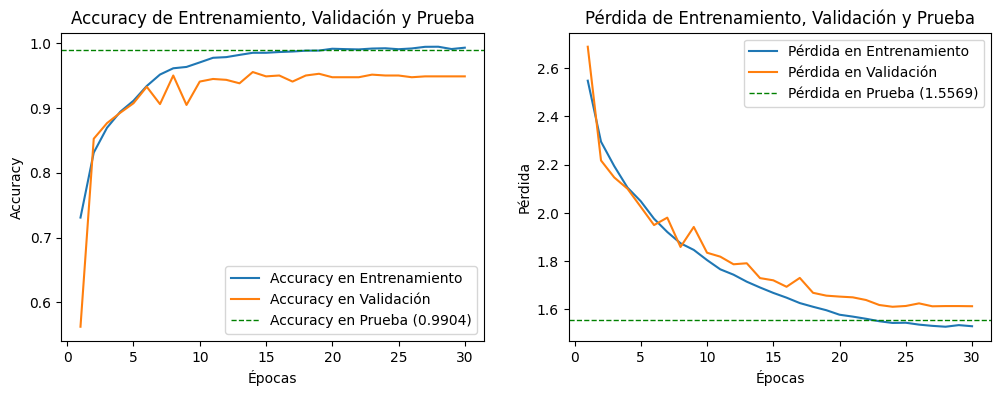

In [32]:

# Función para graficar el historial de entrenamiento y validación
def plot_history(history, test_loss, test_acc):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Gráfico de accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Accuracy en Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Accuracy en Validación')
    plt.axhline(y=test_acc, color='green', linestyle='dashed', linewidth=1, label=f'Accuracy en Prueba ({test_acc:.4f})') 
    plt.legend(loc='lower right')
    plt.title('Accuracy de Entrenamiento, Validación y Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida en Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida en Validación')
    plt.axhline(y=test_loss, color='green', linestyle='dashed', linewidth=1, label=f'Pérdida en Prueba ({test_loss:.4f})') 
    plt.legend(loc='upper right')
    plt.title('Pérdida de Entrenamiento, Validación y Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')

    plt.show()

# Llamada a la función para graficar el historial
plot_history(history, test_loss, test_acc)


In [33]:
# Evaluación en el conjunto de prueba
results = model.evaluate(test_generator)
print(results)

test_loss, test_acc, *other_metrics = results
print('Pérdida en el conjunto de prueba:', test_loss)
print('Precisión en el conjunto de prueba:', test_acc)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9957 - loss: 1.5355 - precision_1: 0.6364 - recall_1: 0.6257  
[1.5569143295288086, 0.9903846383094788, 1.0, 0.981249988079071]
Pérdida en el conjunto de prueba: 1.5569143295288086
Precisión en el conjunto de prueba: 0.9903846383094788


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


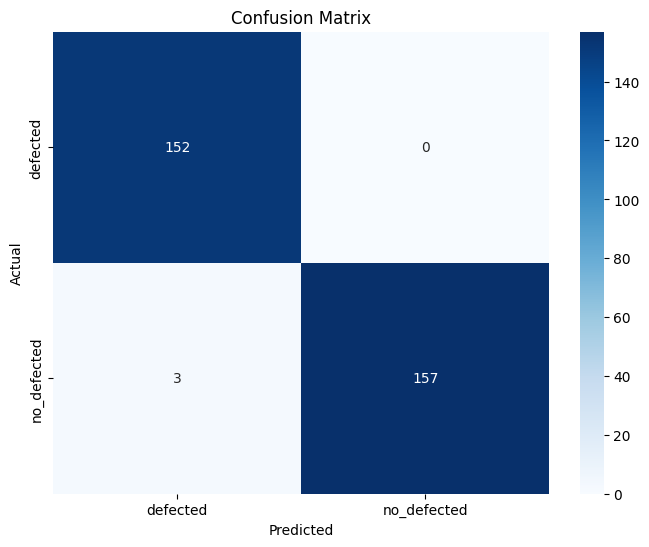

              precision    recall  f1-score   support

    defected       0.98      1.00      0.99       152
 no_defected       1.00      0.98      0.99       160

    accuracy                           0.99       312
   macro avg       0.99      0.99      0.99       312
weighted avg       0.99      0.99      0.99       312



In [34]:
# 1. Predict on the test set (without shuffling)
test_generator.reset()  # Reset generator before prediction
y_pred_proba = model.predict(test_generator)

# 2. Convert probabilities to class labels (threshold 0.5)
y_pred = (y_pred_proba > 0.45).astype(int)

# 3. Generate and display the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Print a classification report for detailed metrics
print(classification_report(test_labels, y_pred, target_names=class_names))

